In [1]:
# import the packages
import pandas as pd
import numpy as np
import random

 #import plot libraries
import seaborn as sns # import seaborn for visualization of data
%matplotlib inline
import matplotlib.pyplot as plt#
import matplotlib as mpl
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)


In [2]:
# import the data from the folder
monday = pd.read_csv('../../data/monday.csv', parse_dates=True,sep = ';')
tuesday = pd.read_csv('../../data/tuesday.csv',  parse_dates=True,sep = ';')
wednesday = pd.read_csv('../../data/wednesday.csv',  parse_dates=True,sep = ';')
thursday = pd.read_csv('../../data/thursday.csv',  parse_dates=True,sep = ';')
friday = pd.read_csv('../../data/friday.csv',  parse_dates=True,sep = ';')
monday.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [3]:
# inspect the data
monday['customer_no']

0          1
1          2
2          3
3          4
4          5
        ... 
4879    1442
4880    1444
4881    1445
4882    1446
4883    1447
Name: customer_no, Length: 4884, dtype: int64

In [4]:
# each day specifies customers with munber. We need to identify each one separately

monday['customer_id'] = 'm-'+(monday['customer_no']).astype(str)
tuesday['customer_id'] = 't-'+(tuesday['customer_no']).astype(str)
wednesday['customer_id'] = 'w-'+(wednesday['customer_no']).astype(str)
thursday['customer_id'] = 'th-'+(thursday['customer_no']).astype(str)
friday['customer_id'] = 'f-'+(friday['customer_no']).astype(str)

In [5]:
# concatenate the matrices
sm1 = monday.append(tuesday, ignore_index = True)
sm2 = sm1.append(wednesday, ignore_index = True)
sm3 = sm2.append(thursday, ignore_index = True)
sm = sm3.append(friday, ignore_index = True)


In [6]:
sm

,timestamp,customer_no,location,customer_id
0,2019-09-02 07:03:00,1,dairy,m-1
1,2019-09-02 07:03:00,2,dairy,m-2
2,2019-09-02 07:04:00,3,dairy,m-3
3,2019-09-02 07:04:00,4,dairy,m-4
4,2019-09-02 07:04:00,5,spices,m-5
...,...,...,...,...
24872,2019-09-06 21:50:00,1500,dairy,f-1500
24873,2019-09-06 21:50:00,1507,checkout,f-1507
24874,2019-09-06 21:50:00,1508,checkout,f-1508
24875,2019-09-06 21:50:00,1509,drinks,f-1509


In [7]:
# sort the matrix by customer_id and timestamp
sort_sm = sm.sort_values(by=['customer_id','timestamp'])
sort_sm =sort_sm.drop(columns = ['customer_no'])
sort_sm

,timestamp,location,customer_id
19752,2019-09-06 07:00:00,dairy,f-1
19764,2019-09-06 07:04:00,spices,f-1
19767,2019-09-06 07:05:00,checkout,f-1
19771,2019-09-06 07:06:00,fruit,f-10
19792,2019-09-06 07:11:00,checkout,f-10
...,...,...,...
12856,2019-09-04 16:53:00,dairy,w-998
12884,2019-09-04 16:57:00,fruit,w-998
12892,2019-09-04 16:59:00,checkout,w-998
12857,2019-09-04 16:53:00,fruit,w-999


In [8]:
sort_sm['location_next'] = sort_sm.location.shift(-1) 

In [9]:
sort_sm.head()

,timestamp,location,customer_id,location_next
19752,2019-09-06 07:00:00,dairy,f-1,spices
19764,2019-09-06 07:04:00,spices,f-1,checkout
19767,2019-09-06 07:05:00,checkout,f-1,fruit
19771,2019-09-06 07:06:00,fruit,f-10,checkout
19792,2019-09-06 07:11:00,checkout,f-10,fruit


In [10]:
sort_sm.location.unique()


array(['dairy', 'spices', 'checkout', 'fruit', 'drinks'], dtype=object)

In [11]:
# notes about normalize use 
# If passed ‘index’ will normalize over each row.
# default is False , which will give you the count

P = pd.crosstab(
    sort_sm['location'], 
    sort_sm['location_next'], normalize='index')
P

location_next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,0.000000,0.287487,0.153317,0.377697,0.181499
dairy,0.390041,0.001069,0.222697,0.190212,0.195982
drinks,0.536748,0.027401,0.000000,0.219206,0.216645
fruit,0.498829,0.237993,0.137056,0.000390,0.125732
spices,0.250666,0.323655,0.272776,0.152637,0.000266


In [12]:
Pc = pd.crosstab(
    sort_sm['location'], 
    sort_sm['location_next'])
Pc

location_next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,0,2132,1137,2801,1346
dairy,1825,5,1042,890,917
drinks,2096,107,0,856,846
fruit,2555,1219,702,2,644
spices,941,1215,1024,573,1


In [13]:
type(P)
weigh = P.values

In [14]:
states = sort_sm.location.unique()
state= ['checkout', 'dairy','drinks','fruit','spices']


In [15]:
probs = P.to_dict(orient='index')
# convert internal values, which is a dict to a list
for key in probs.keys():
    probs[key] = list(probs[key].values())

In [16]:
probs

{'checkout': [0.0,
  0.28748651564185546,
  0.15331715210355987,
  0.37769687162891047,
  0.1814994606256742],
 'dairy': [0.3900406069673007,
  0.0010686044026501388,
  0.22269715751228894,
  0.19021158367172472,
  0.19598204744603548],
 'drinks': [0.5367477592829706,
  0.027400768245838668,
  0.0,
  0.21920614596670934,
  0.21664532650448143],
 'fruit': [0.49882858258492774,
  0.23799297149550958,
  0.13705583756345177,
  0.0003904724716907458,
  0.12573213588442014],
 'spices': [0.2506659563132658,
  0.32365476824720296,
  0.27277570591369205,
  0.15263718700053278,
  0.0002663825253063399]}

In [17]:
# to get the actual string representing the state, you then need to do the following 
result = []
for department in state:
    result.append(random.choices(states, weights=probs[department]))
result



[['drinks'], ['dairy'], ['dairy'], ['dairy'], ['checkout']]

In [18]:
def next_step(current_step,stat, prob):
    prediction = random.choices(stat, weights=prob[current_step])
    print(f'For the customer who is in "{current_step}" department it is most probable that will move to "{prediction[0]}" after.')
    return prediction

In [19]:
ns = next_step(np.random.choice(state[1:-1], size=1)[0],states,probs)

For the customer who is in "fruit" department it is most probable that will move to "spices" after.


# EDA

- Calculate the total number of customers in each section

In [20]:
sort_sm.head()

,timestamp,location,customer_id,location_next
19752,2019-09-06 07:00:00,dairy,f-1,spices
19764,2019-09-06 07:04:00,spices,f-1,checkout
19767,2019-09-06 07:05:00,checkout,f-1,fruit
19771,2019-09-06 07:06:00,fruit,f-10,checkout
19792,2019-09-06 07:11:00,checkout,f-10,fruit


In [21]:
# Total number of customers in each section for all week and independent of the times being there per customer 
sort_sm.location_next
sort_sm.groupby("location_next").count()

,timestamp,location,customer_id
location_next,,,
checkout,7417,7417,7417
dairy,4678,4678,4678
drinks,3905,3905,3905
fruit,5122,5122,5122
spices,3754,3754,3754


- Calculate the total number of customers in each section over time

In [22]:
sort_sm['Time'] = pd.to_datetime(sort_sm['timestamp']).dt.hour
sort_sm['Day'] = pd.to_datetime(sort_sm['timestamp']).dt.date

In [23]:
Group = sort_sm.groupby(["location",'Time']).count()

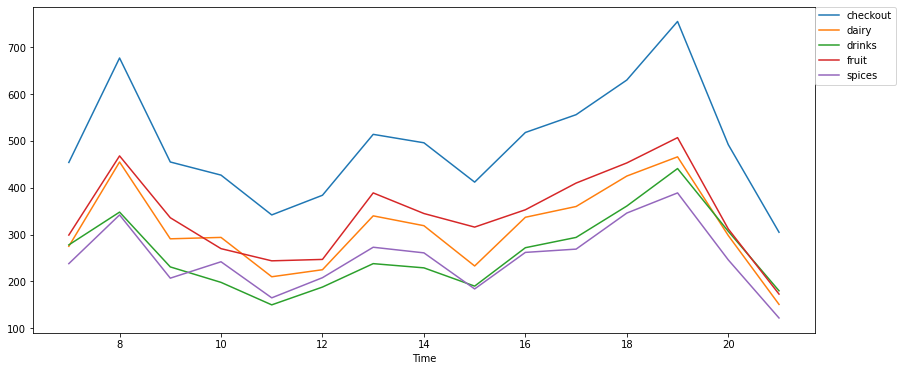

In [24]:
Group["customer_id"].unstack(level=0).plot.line()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

In [25]:
Group.reset_index()

,location,Time,timestamp,customer_id,location_next,Day
0,checkout,7,454,454,454,454
1,checkout,8,677,677,677,677
2,checkout,9,455,455,455,455
3,checkout,10,427,427,427,427
4,checkout,11,342,342,342,342
...,...,...,...,...,...,...
70,spices,17,269,269,269,269
71,spices,18,346,346,346,346
72,spices,19,389,389,389,389
73,spices,20,246,246,246,246


<AxesSubplot:xlabel='Time', ylabel='customer_id'>

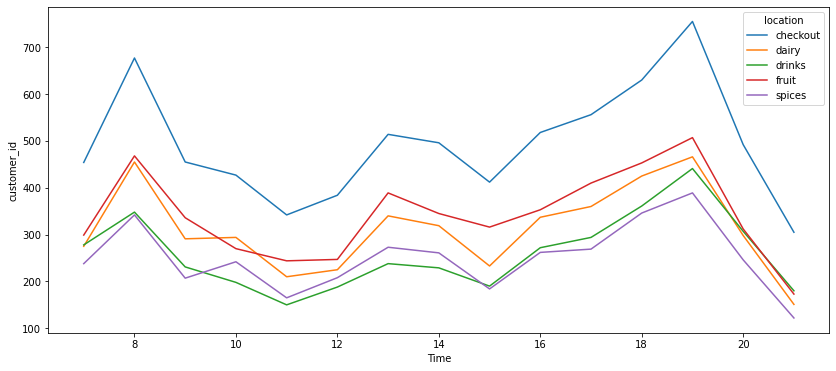

In [26]:
sns.lineplot(data=Group.reset_index(), x="Time", y="customer_id", hue="location")

- Calculate the time each customer spent in the market

In [27]:
# Create from timestamps the minutes and hour  information
sort_sm['minutes'] = pd.to_datetime(sort_sm['timestamp']).dt.minute
sort_sm['hour'] = pd.to_datetime(sort_sm['timestamp']).dt.hour

In [28]:
# Count the time in minutes
sort_sm['total_minutes']  = sort_sm.hour * 60 + sort_sm.minutes
sort_sm

,timestamp,location,customer_id,location_next,Time,Day,minutes,hour,total_minutes
19752,2019-09-06 07:00:00,dairy,f-1,spices,7,2019-09-06,0,7,420
19764,2019-09-06 07:04:00,spices,f-1,checkout,7,2019-09-06,4,7,424
19767,2019-09-06 07:05:00,checkout,f-1,fruit,7,2019-09-06,5,7,425
19771,2019-09-06 07:06:00,fruit,f-10,checkout,7,2019-09-06,6,7,426
19792,2019-09-06 07:11:00,checkout,f-10,fruit,7,2019-09-06,11,7,431
...,...,...,...,...,...,...,...,...,...
12856,2019-09-04 16:53:00,dairy,w-998,fruit,16,2019-09-04,53,16,1013
12884,2019-09-04 16:57:00,fruit,w-998,checkout,16,2019-09-04,57,16,1017
12892,2019-09-04 16:59:00,checkout,w-998,fruit,16,2019-09-04,59,16,1019
12857,2019-09-04 16:53:00,fruit,w-999,checkout,16,2019-09-04,53,16,1013


In [29]:
# Aggregate as a function of maximun and minimum time in supermarket per customer
test  = sort_sm.groupby(by = ['customer_id'])['total_minutes'].agg(['min','max'])
test['minutes_stay'] = test['max'] - test['min']
test['minutes_stay']

customer_id
f-1        5
f-10       5
f-100      1
f-1000     1
f-1001    10
          ..
w-995     28
w-996     11
w-997     22
w-998      6
w-999      1
Name: minutes_stay, Length: 7445, dtype: int64

In [61]:
rand_customer = np.random.choice(sort_sm['total_minutes'],size=1)[0]
DAY = test.index[rand_customer][0]
if DAY == 'f':
    day_mf = 'friday'
elif DAY == 'm':
    day_mf = 'monday'
elif DAY == 't':
    day_mf = 'tuesday'
elif DAY == 'w':
    day_mf = 'wednesday'
elif DAY == 'th':
    day_mf = 'thursday'
print(f'The customer No.{test.index[rand_customer][2:]} on {day_mf} stayed in the market for {test.minutes_stay[rand_customer]} minutes.')

The customer No.7 on friday stayed in the market for 3 minutes.
